# 1. Data Preprocessing

Bu bölümde regresyon modeli için veri seti hazırlanmıştır.  
İlk olarak veri seti yüklenmiş, gereksiz sütunlar çıkarılmış ve hedef (y) ile özellikler (X) ayrılmıştır.  

- **Customer ID** modeli etkilemeyen bir tanımlayıcı olduğu için çıkarılmıştır.  
- **Purchase Amount (USD)** regresyon modelinde tahmin edilmek üzere hedef değişken olarak seçilmiştir.  
- Kategorik değişkenler makine öğrenmesi modellerinin işleyebilmesi için **One-Hot Encoding** yöntemiyle sayısal forma dönüştürülmüştür.  
- Veri, model performansını değerlendirmek için %80 eğitim ve %20 test olacak şekilde **train-test split** işlemi uygulanarak ayrılmıştır.

Aşağıdaki hücrede veri hazırlama adımlarının tamamı gerçekleştirilmiştir.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/shopping_behavior_updated.csv')

# Gereksiz kolon sil
df = df.drop(columns=["Customer ID"])

# Hedef değişken
y = df["Purchase Amount (USD)"]

# Özellikler
X = df.drop(columns=["Purchase Amount (USD)"])

# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((3120, 129), (780, 129))

In [3]:
# --- Veri Seti İstatistiksel Özet ---
print("Veri Seti Sayısal Değişken İstatistikleri:")
display(df.describe().T)

print("\nKategorik Değişken Özetleri:")
display(df.describe(include='object').T)

Veri Seti Sayısal Değişken İstatistikleri:


,count,mean,std,min,25%,50%,75%,max
Age,3900.0,44.068462,15.207589,18.0,31.0,44.0,57.0,70.0
Purchase Amount (USD),3900.0,59.764359,23.685392,20.0,39.0,60.0,81.0,100.0
Review Rating,3900.0,3.749949,0.716223,2.5,3.1,3.7,4.4,5.0
Previous Purchases,3900.0,25.351538,14.447125,1.0,13.0,25.0,38.0,50.0



Kategorik Değişken Özetleri:


,count,unique,top,freq
Gender,3900,2,Male,2652
Item Purchased,3900,25,Blouse,171
Category,3900,4,Clothing,1737
Location,3900,50,Montana,96
Size,3900,4,M,1755
Color,3900,25,Olive,177
Season,3900,4,Spring,999
Subscription Status,3900,2,No,2847
Shipping Type,3900,6,Free Shipping,675
Discount Applied,3900,2,No,2223


# 2. Linear Regression Modeli

Bu bölümde regresyon problemi için temel (baseline) model olarak **Linear Regression** kullanılmıştır.    

Model eğitilmeden önce veriler eğitim (train) ve test olarak ikiye ayrılmıştır.  
Bu bölümde yapılan işlemler:

- LinearRegression sınıfı kullanılarak model oluşturulmuştur.
- Eğitim verisi (X_train, y_train) ile model eğitilmiştir.
- Test verisi üzerinde tahmin yapılmıştır.
- Model performansını değerlendirmek için aşağıdaki metrikler hesaplanmıştır:
  - **MAE (Mean Absolute Error):** Ortalama mutlak hata.
  - **MSE (Mean Squared Error):** Ortalama kare hata.
  - **RMSE (Root Mean Squared Error):** MSE'nin karekökü, hata büyüklüğünü daha anlamlı gösterir.
  - **R² Score:** Modelin veriyi ne kadar açıkladığını gösterir. 1’e yakın olması beklenir.

Aşağıdaki hücrede Linear Regression modelinin eğitimi ve değerlendirme metrikleri yer almaktadır.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modeli oluştur
lr_model = LinearRegression()

# Eğit
lr_model.fit(X_train, y_train)

# Tahmin et
y_pred_lr = lr_model.predict(X_test)

# Değerlendirme
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_mse, lr_rmse, lr_r2

(20.902324771906557,
 575.3492158352354,
 np.float64(23.986438164830464),
 -0.028176091376487022)

Linear Regression sonuçlarında R² değerinin çok düşük (hatta negatif) çıkması, veri setindeki özellikler ile hedef değişken (Purchase Amount) arasında güçlü bir doğrusal ilişki olmadığını göstermektedir. Bu durum, verinin doğasından veya özelliklerin (features) hedefi açıklamakta yetersiz kalmasından kaynaklanmaktadır.

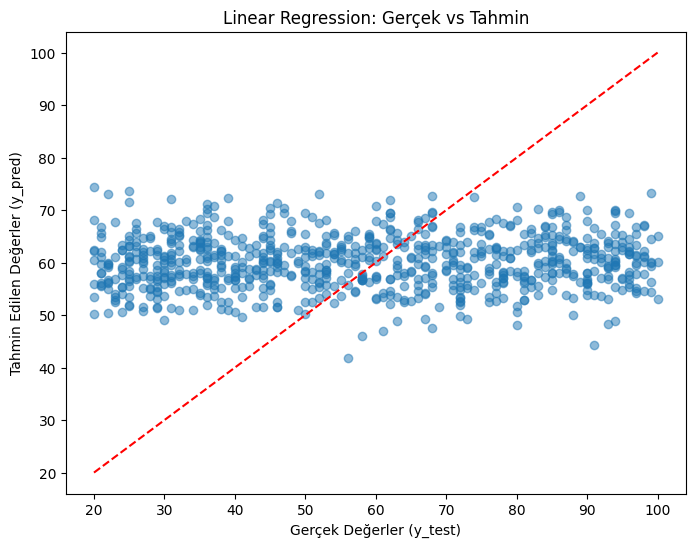

In [5]:
import matplotlib.pyplot as plt

# Gerçek vs Tahmin Grafiği
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Gerçek Değerler (y_test)")
plt.ylabel("Tahmin Edilen Değerler (y_pred)")
plt.title("Linear Regression: Gerçek vs Tahmin")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--') # İdeal tahmin çizgisi
plt.show()

# 3. Random Forest Regressor Modeli

Bu bölümde regresyon problemini çözmek için Random Forest Regressor modeli kullanılmıştır.

Bu yöntem:

- Doğrusal olmayan ilişkileri öğrenebilir,

- Gürültülü verilerden daha az etkilenir,

- Aşırı öğrenmeye (overfitting) karşı dayanıklıdır,

- Genelde doğrusal modellere göre daha yüksek başarı sağlar.

Model eğitilmeden önce veriler eğitim (train) ve test setlerine ayrılmıştır.
Bu bölümde yapılan işlemler:

- RandomForestRegressor sınıfı kullanılarak model oluşturulmuştur.

- Eğitim verisi (X_train, y_train) ile model eğitilmiştir.

- Test verisi kullanılarak tahmin yapılmıştır.

- Model performansını değerlendirmek için aşağıdaki metrikler hesaplanmıştır:

  - MAE (Mean Absolute Error): Ortalama mutlak hata.

  - MSE (Mean Squared Error): Ortalama kare hata.

  - RMSE (Root Mean Squared Error): MSE’nin karekökü, hatanın büyüklüğünü daha anlamlı gösterir.

  - R² Score: Modelin bağımlı değişken varyansını ne kadar açıkladığını gösterir (1’e yakınsa model başarılıdır).

Aşağıdaki hücrede Random Forest modelinin eğitimi ve değerlendirme metrikleri yer almaktadır.

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Eğit
rf_model.fit(X_train, y_train)

# Tahmin
y_pred_rf = rf_model.predict(X_test)

# Değerlendirme
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_mse, rf_rmse, rf_r2

(21.002108974358972,
 577.9755813782052,
 np.float64(24.04112271459478),
 -0.03286953004673254)

Random Forest modeli de Linear Regression gibi negatif R² skoru vermiştir. Normalde Random Forest'ın doğrusal olmayan ilişkileri yakalayarak daha iyi performans göstermesi beklenirdi. Ancak her iki modelin de başarısız olması, veri setindeki özniteliklerin (features) hedef değişkeni (Purchase Amount) tahmin etmek için yeterli bilgi barındırmadığını göstermektedir.

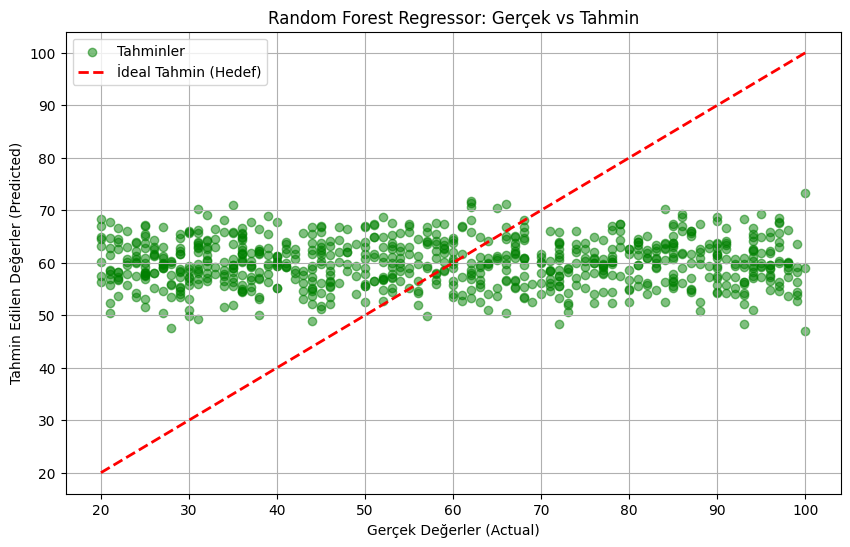

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green', label='Tahminler')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='İdeal Tahmin (Hedef)')

plt.xlabel('Gerçek Değerler (Actual)')
plt.ylabel('Tahmin Edilen Değerler (Predicted)')
plt.title('Random Forest Regressor: Gerçek vs Tahmin')
plt.legend()
plt.grid(True)
plt.show()

# 4. Modellerin Karşılaştırılması

Bu bölümde Linear Regression ve Random Forest Regressor modellerinin performans metrikleri tek bir tablo halinde karşılaştırılmıştır.

Tablo aşağıdaki metrikleri içermektedir:

- **MAE** (Mean Absolute Error)
- **MSE** (Mean Squared Error)
- **RMSE** (Root Mean Squared Error)
- **R² Score**

Bu tablo, hangi modelin performans açısından daha başarılı olduğunu kolayca görmemizi sağlar.

In [8]:
result_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [lr_mae, rf_mae],
    "MSE": [lr_mse, rf_mse],
    "RMSE": [lr_rmse, rf_rmse],
    "R2 Score": [lr_r2, rf_r2]
})
result_df_rounded = result_df.round(4)
print(result_df_rounded)


               Model      MAE       MSE     RMSE  R2 Score
0  Linear Regression  20.9023  575.3492  23.9864   -0.0282
1      Random Forest  21.0021  577.9756  24.0411   -0.0329


# 5. Sınıflandırma (Classification) Modeli

Önceki bölümlerde uygulanan Regresyon modelleri (Linear Regression ve Random Forest Regressor), hedef değişken olan `Purchase Amount (USD)` ile diğer özellikler arasında güçlü bir ilişki bulunmadığı için düşük performans göstermiştir. Bu durum, veri setinin sayısal bir değeri tahmin etmekten ziyade, kategorik sınıfları ayırmak için daha uygun olabileceğini düşündürmüştür.

Bu bölümde, problemin türü değiştirilerek bir **Sınıflandırma (Classification)** problemi ele alınacaktır.

* **Hedef Değişken:** `Subscription Status` (Müşterinin abonelik durumu: **Yes** veya **No**)
* **Amaç:** Müşterinin demografik özellikleri ve alışveriş geçmişine bakarak abone olup olmadığını tahmin etmek.
* **Kullanılan Modeller:**
    1.  **Logistic Regression**
    2.  **Random Forest Classifier**

Veriler yeniden işlenmiş, hedef değişken `1 (Yes)` ve `0 (No)` olarak kodlanmış ve modellerin başarısı **Accuracy, Precision, Recall ve F1-Score** metrikleriyle değerlendirilmiştir.

--- Logistic Regression Sonuçları ---
Accuracy (Doğruluk): 0.8012820512820513

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85       558
           1       0.62      0.81      0.70       222

    accuracy                           0.80       780
   macro avg       0.76      0.80      0.77       780
weighted avg       0.83      0.80      0.81       780

------------------------------

--- Random Forest Classifier Sonuçları ---
Accuracy (Doğruluk): 0.8205128205128205

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       558
           1       0.63      0.91      0.74       222

    accuracy                           0.82       780
   macro avg       0.79      0.85      0.80       780
weighted avg       0.86      0.82      0.83       780



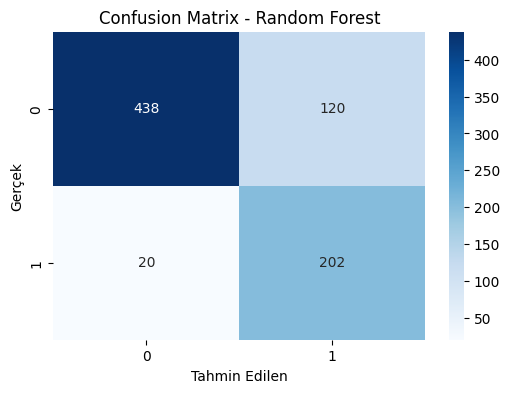

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veri Hazırlığı
df_class = pd.read_csv('shopping_behavior_updated.csv')
df_class = df_class.drop(columns=["Customer ID"])

# Hedef Değişkeni Sayısallaştır (Yes: 1, No: 0)
df_class['Subscription Status'] = df_class['Subscription Status'].apply(lambda x: 1 if x == 'Yes' else 0)

# Hedef (y) ve Özellikler (X)
y_class = df_class['Subscription Status']
X_class = df_class.drop(columns=['Subscription Status'])

# One-Hot Encoding
X_class = pd.get_dummies(X_class, drop_first=True)

# Train-Test Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# --- Model 1: Logistic Regression ---
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_c, y_train_c)
y_pred_log = log_model.predict(X_test_c)

# --- Model 2: Random Forest Classifier ---
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train_c, y_train_c)
y_pred_rfc = rfc_model.predict(X_test_c)

# --- Sonuçları Yazdır ---
print("--- Logistic Regression Sonuçları ---")
print("Accuracy (Doğruluk):", accuracy_score(y_test_c, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_log))

print("-" * 30)

print("\n--- Random Forest Classifier Sonuçları ---")
print("Accuracy (Doğruluk):", accuracy_score(y_test_c, y_pred_rfc))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_rfc))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_c, y_pred_rfc), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

### Sonuçların Değerlendirilmesi ve Yorumu

Elde edilen sınıflandırma sonuçları, regresyon analizine kıyasla oldukça başarılıdır. Modellerin performans analizi aşağıdadır:

**1. Genel Başarı (Accuracy):**
* **Logistic Regression:** %80.1
* **Random Forest Classifier:** %82.0
* **Yorum:** Her iki model de %80 barajını aşmıştır. Bu durum, veri setindeki özniteliklerin (Yaş, Cinsiyet, Harcama Sıklığı vb.) müşterinin abonelik durumunu ayırt etmede **anlamlı bilgi taşıdığını** göstermektedir. Regresyonun aksine, sınıflandırma modelleri veri setindeki örüntüleri (patterns) başarıyla yakalamıştır.

**2. Model Karşılaştırması:**
Random Forest Classifier (%82), Logistic Regression modeline göre daha yüksek performans göstermiştir. Bu beklenen bir durumdur çünkü Random Forest, verideki doğrusal olmayan karmaşık ilişkileri daha iyi modelleyebilmektedir.

**3. Recall (Duyarlılık) Analizi - Kritik Bulgular:**
* Özellikle **Random Forest** modelinin `1` (Abone Olanlar) sınıfı için **Recall değeri 0.91** çıkmıştır.
* **Bu ne anlama geliyor?** Model, gerçekte abone olan müşterilerin **%91'ini** doğru tespit etmiştir. Bir pazarlama stratejisi için bu çok değerli bir sonuçtur; potansiyel veya mevcut aboneleri kaçırma riskimiz çok düşüktür.

**4. Sınıflar Arası Dengesizlik (Class Imbalance):**
Veri setinde `No` sınıfı daha ağırlıklı olmasına rağmen, modellerimiz (özellikle Random Forest) azınlık olan `Yes` sınıfını tahmin etmede (F1-Score: 0.74) gayet başarılı olmuştur.

**Genel Sonuç:**
Veri seti, "Ne kadar harcayacak?" (Regresyon) sorusuna cevap vermekte yetersiz kalsa da, "Bu müşteri abone mi?" (Sınıflandırma) sorusuna yüksek başarıyla cevap vermektedir. En iyi sonucu veren model **Random Forest Classifier** olmuştur.

Öznitelik Önem Düzeyleri Tablosu:


,Özellik,Önem Derecesi
117,Promo Code Used_Yes,0.213340
116,Discount Applied_Yes,0.212169
1,Purchase Amount (USD),0.040992
4,Gender_Male,0.040871
3,Previous Purchases,0.040157
0,Age,0.038757
2,Review Rating,0.033296
81,Size_M,0.008133
110,Season_Winter,0.007549
109,Season_Summer,0.007444


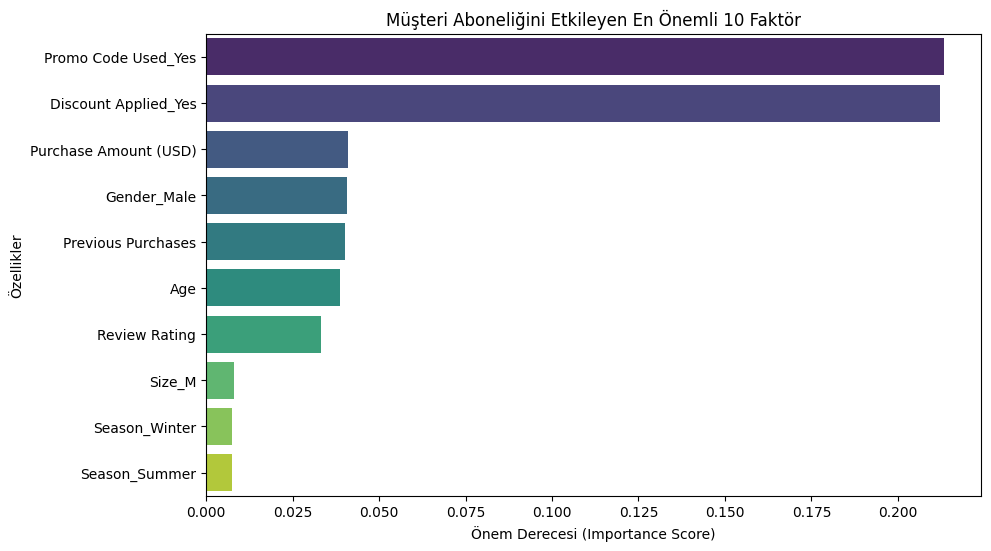

In [10]:
# Random Forest modeline göre hangi özelliklerin (feature) tahmin üzerinde ne kadar etkisi var?

importances = rfc_model.feature_importances_
feature_names = X_class.columns

# Tablo oluştur
feature_importance_df = pd.DataFrame({
    'Özellik': feature_names,
    'Önem Derecesi': importances
}).sort_values(by='Önem Derecesi', ascending=False)

print("Öznitelik Önem Düzeyleri Tablosu:")
display(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Önem Derecesi', y='Özellik', hue='Özellik', data=feature_importance_df.head(10), palette='viridis')
plt.title('Müşteri Aboneliğini Etkileyen En Önemli 10 Faktör')
plt.xlabel('Önem Derecesi (Importance Score)')
plt.ylabel('Özellikler')
plt.show()